In [1]:
import typing
from collections import namedtuple
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from matplotlib.backends.backend_pgf import FigureCanvasPgf

from evaluation.evaluateTools import is_layout_sparse, parse_for_memory_use, write_results_file

matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

from evaluation import evaluateTools as et


In [2]:
%config InlineBackend.figure_format = 'svg'

In [3]:
%%html
<style>
.output_svg div{
  width: 150% !important;
  height: 150% !important;
}
</style>

## matmul single static -O3  8x8x8 seed: 0

load results:

In [4]:
base_dir = f"{et.RESULTS_DIR_BASE}/matmul"
experiment_name = "single_static_O3_8.8.8_0"
# base_dir = f"{et.RESULTS_DIR_BASE}/sparseSuite"
# experiment_name = "Rajat21_O4"
experiment_dir = f"{base_dir}/{experiment_name}"
figure_dir = f"{et.FIGURES_DIR}/{experiment_name}"
data_dir = f"{et.OUTPUT_DATA_DIR}/{experiment_name}"
os.makedirs(figure_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)
print(experiment_dir)
results = et.load_results_file(f"{experiment_dir}/results.csv", columns = [("layout", int), ("order", int), ("repeats", int), ("runs", int), ("time", float), ("finished", et.parse_bool), ("correct", et.parse_bool)])

layout_graph, layouts = et.load_dlt_layouts(experiment_dir)

print(f"number of results: {len(results)}")
finished = [r for r in results if r.finished]
print(f"number that finished: {len(finished)}")
assert all(r.time >= 0 for r in finished)
assert all(r.correct for r in finished)
full_tests = [r for r in finished if r.repeats >= 0]
print(f"number of full tests: {len(full_tests)}")
trials = [r for r in finished if r.repeats == -1]
print(f"number of trials: {len(trials)}")
tests = {}
for r in full_tests:
    tests.setdefault((r.layout, r.order), []).append(r)


stats = []
Stat = namedtuple('Stat', typing.cast(list[str], ["layout", "order", "mean", "min", "max", "std", "median", "runs", "entries"]))
for ((l, o), rs) in tests.items():
    ts = [r.time/r.runs for r in rs]
    t_mean = np.mean(ts)
    t_min = np.min(ts)
    t_max = np.max(ts)
    t_std = np.std(ts)
    t_median = np.median(ts)
    
    runss = [r.runs for r in rs]
    assert len(set(runss)) == 1
    runs = runss[0]
    stats.append(Stat(l, o, t_mean, t_min, t_max, t_std, t_median, runs, rs))

std_min = np.min([s.std for s in stats])
std_max = np.max([s.std for s in stats])
print(f"smallest standard deviation for results : {std_min}")
print(f"largest standard deviation for results : {std_max}")
print(f"fastest mean result : {min([s.mean for s in stats])}")

/home/edward/Documents/phd/Results/Watt-2025-01-09/results/matmul/single_static_O3_8.8.8_0
number of results: 3136
number that finished: 3136
number of full tests: 2352
number of trials: 784
smallest standard deviation for results : 2.9862977397527166e-09
largest standard deviation for results : 1.9780547976333693e-06
fastest mean result : 1.2228293000589474e-05


/tmp/ipykernel_36294/964586016.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


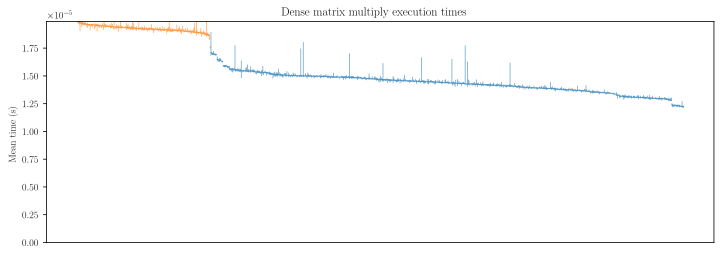

In [5]:
def run_cell():
    ordered_stats = sorted(stats, key=lambda s: s.median, reverse=True)
    
    x = np.arange(len(ordered_stats))
    y = np.array([s.median for s in ordered_stats])
    y_err_low = np.array([y_v - s.min for s, y_v in zip(ordered_stats, y)])
    y_err_high = np.array([s.max - y_v for s, y_v in zip(ordered_stats, y)])
    colors = np.array(['C0' if s.runs >100 else 'C1' for s in ordered_stats])
    fig = plt.figure(figsize=(12,4), dpi=300)
    ax = fig.add_subplot()
    for pos, mean_val, min_val, max_val, color in zip(x,y,y_err_low,y_err_high,colors):
        ax.errorbar([pos], [mean_val], yerr=[[min_val], [max_val]], color = color, elinewidth=0.5, fmt='o', markersize=0.2)
    ax.set_ylim(0, max(y))
    ax.set_title("Dense matrix multiply execution times")
    ax.set_ylabel("Mean time (s)")
    ax.set_xticklabels([])
    ax.set_xticks([])
    fig.show()
    fig.savefig(f"{figure_dir}/times.pgf")
    fig.savefig(f"{figure_dir}/times.pdf")
run_cell()


/tmp/ipykernel_36294/2337088081.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


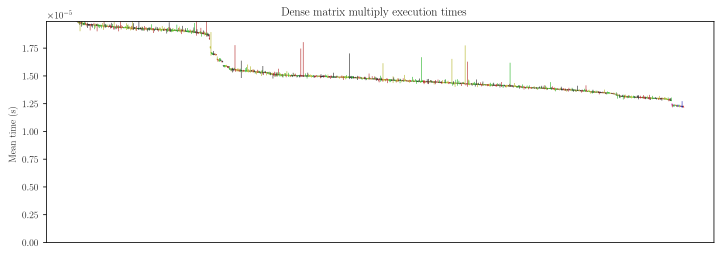

In [6]:
def run_cell():
    ordered_stats = sorted(stats, key=lambda s: s.median, reverse=True)
    
    x = np.arange(len(ordered_stats))
    y = np.array([s.median for s in ordered_stats])
    y_err_low = np.array([y_v - s.min for s, y_v in zip(ordered_stats, y)])
    y_err_high = np.array([s.max - y_v for s, y_v in zip(ordered_stats, y)])
    
    fastest_layout_id = ordered_stats[-1].layout
    fastest_layouts = {l for l in layouts if l.number == fastest_layout_id}
    assert len(fastest_layouts) == 1
    fastest_layout = fastest_layouts.pop()
    fastest_layout_mapping = {s.data: p for (s, p) in fastest_layout.make_ptr_dict().items()}
    target_names = ["R_0", "R_1", "R_2"]
    targets = [fastest_layout_mapping[tn] for tn in target_names]
    colours = []
    for s in ordered_stats:
        ls = {l for l in layouts if l.number == s.layout}
        assert len(ls) == 1
        l_map = {id.data: p for id, p in ls.pop().make_ptr_dict().items()}
        l_targets = [l_map[tn] for tn in target_names]
        r, g, b = [l_t == t for l_t, t in zip(l_targets, targets)]
        colour = (float(r)*0.65, float(g)*0.65, float(b)*0.65)
        if r and g and b:
            colour = (1,0,0)
        colours.append(colour)
    
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot()
    for pos, mean_val, min_val, max_val, color in zip(x,y,y_err_low,y_err_high,colours):
        ax.errorbar([pos], [mean_val], yerr=[[min_val], [max_val]], color = color, elinewidth=0.5, fmt='o', markersize=0.2)
    ax.set_ylim(0, max(y))
    ax.set_title("Dense matrix multiply execution times")
    ax.set_ylabel("Mean time (s)")
    ax.set_xticklabels([])
    ax.set_xticks([])
    fig.show()
    fig.savefig(f"{figure_dir}/times_layout_similarity.pgf")
    fig.savefig(f"{figure_dir}/times_layout_similarity.pdf")

run_cell()

/tmp/ipykernel_36294/1109288266.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


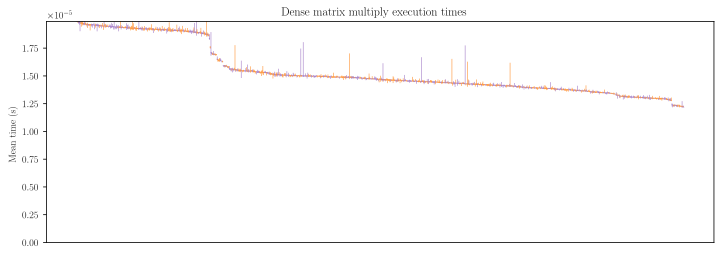

In [7]:
def run_cell():
    
    ordered_stats = sorted(stats, key=lambda s: s.median, reverse=True)
    
    x = np.arange(len(ordered_stats))
    y = np.array([s.median for s in ordered_stats])
    y_err_low = np.array([y_v - s.min for s, y_v in zip(ordered_stats, y)])
    y_err_high = np.array([s.max - y_v for s, y_v in zip(ordered_stats, y)])
    colors = np.array([f"C{s.order}" for s in ordered_stats])
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot()
    for pos, mean_val, min_val, max_val, color in zip(x,y,y_err_low,y_err_high,colors):
        ax.errorbar([pos], [mean_val], yerr=[[min_val], [max_val]], color = color, elinewidth=0.5, fmt='o', markersize=0.2)
    ax.set_ylim(0, max(y))
    ax.set_title("Dense matrix multiply execution times")
    ax.set_ylabel("Mean time (s)")
    ax.set_xticklabels([])
    ax.set_xticks([])
    fig.show()
    fig.savefig(f"{figure_dir}/times_by_order.pgf")
    fig.savefig(f"{figure_dir}/times_by_order.pdf")
run_cell()

/tmp/ipykernel_36294/2470486252.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


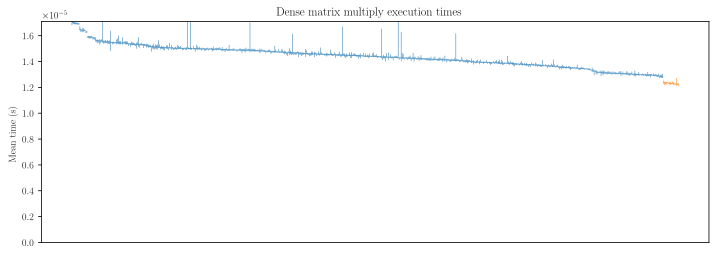

In [8]:
def run_cell():
    ordered_stats = sorted(stats, key=lambda s: s.median, reverse=True)
    ordered_stats = [o for o in ordered_stats if o.runs == 1000]
    x = np.arange(len(ordered_stats))
    y = np.array([s.median for s in ordered_stats])
    y_err_low = np.array([y_v - s.min for s, y_v in zip(ordered_stats, y)])
    y_err_high = np.array([s.max - y_v for s, y_v in zip(ordered_stats, y)])

    target_names = ["R_0", "R_1", "R_2"]
    
    colours = []
    is_sparse = []
    for s in ordered_stats:
        ls = {l for l in layouts if l.number == s.layout}
        assert len(ls) == 1
        l_map = {id.data: p for id, p in ls.pop().make_ptr_dict().items()}
        l_targets = [l_map[tn] for tn in target_names]
        sparse = any([is_layout_sparse(l_t.layout) for l_t in l_targets])
        is_sparse.append(sparse)
        colour = "C0" if sparse else "C1"
        colours.append(colour)
    
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot()
    for pos, mean_val, min_val, max_val, color in zip(x,y,y_err_low,y_err_high,colours):
        ax.errorbar([pos], [mean_val], yerr=[[min_val], [max_val]], color = color, elinewidth=0.5, fmt='o', markersize=0.2)
    ax.set_ylim(0, max(y))
    ax.set_title("Dense matrix multiply execution times")
    ax.set_ylabel("Mean time (s)")
    ax.set_xticklabels([])
    ax.set_xticks([])
    fig.show()
    fig.savefig(f"{figure_dir}/times_layout_is_sparse.pgf")
    fig.savefig(f"{figure_dir}/times_layout_is_sparse.pdf")

    et.write_results_file(f"{data_dir}/times_layout_is_sparse.csv", ("x", "time","is_sparse"), [(i, t, s) for i, (t, s) in enumerate(zip(y, is_sparse))])
run_cell()

/tmp/ipykernel_36294/1031858553.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


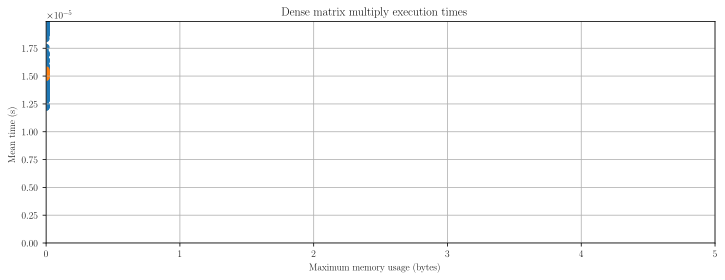

In [9]:
def run_cell():
    ordered_stats = sorted(stats, key=lambda s: s.median, reverse=True)
    
    
    memory_stats = []
    for stat in ordered_stats:
        memory_test_expr_dir = experiment_dir
        memory_stats.append(parse_for_memory_use(memory_test_expr_dir, (stat.layout,stat.order), ()))
    
    x = np.array([ms[0].allocated_worst_case+ms[1].allocated_worst_case for ms in memory_stats])
    y = np.array([s.median for s in stats])
    

    target_names = ["R_0", "R_1", "R_2"]
    
    colours = []
    for s in ordered_stats:
        ls = {l for l in layouts if l.number == s.layout}
        assert len(ls) == 1
        l_map = {id.data: p for id, p in ls.pop().make_ptr_dict().items()}
        l_targets = [l_map[tn] for tn in target_names]
        sparse = any([is_layout_sparse(l_t.layout) for l_t in l_targets])
        colour = "C0" if sparse else "C1"
        colours.append(colour)
    
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot()
    ax.scatter(x,y,c=colours)
    ax.set_ylim(0, max(y))
    ax.set_xlim(0, 5)
    ax.set_title("Dense matrix multiply execution times")
    ax.set_ylabel("Mean time (s)")
    ax.set_xlabel("Maximum memory usage (bytes)")
    ax.grid(True, which='both')
    fig.show()
    fig.savefig(f"{figure_dir}/times_max_mem.pgf")
    fig.savefig(f"{figure_dir}/times_max_mem.pdf")

run_cell()